# Modules

In [ ]:
# Remember to not normalize in the clip loss

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
import os
path = '/content/drive/My Drive/science/stellarclip/'
os.chdir(path)

In [ ]:
%load_ext autoreload
%autoreload 2

import sys

import matplotlib.pyplot as plt
import pandas as pd
import torch
from sklearn import datasets
from sklearn.linear_model import LogisticRegression
from sklearn.manifold import TSNE
from sklearn.metrics import (ConfusionMatrixDisplay, classification_report,
                             confusion_matrix)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.optim import Adam
from torch.utils.data import DataLoader

sys.path.append("../")

from scarf.loss import NTXent, CLIPLoss
from scarf.model import SCARF, DualModalitySCARF

from example.dataset import ExampleDataset
from example.utils import dataset_embeddings, fix_seed, train_epoch, train_epoch_old

import numpy as np
seed = 1234
fix_seed(seed)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Data

In [ ]:
def_last_prob_df = pd.read_csv('./data/last_new.csv')
def_second_prob_df = pd.read_csv('./data/second_new.csv')
def_first_prob_df = pd.read_csv('./data/most_probable_new.csv')

In [ ]:
def_first_prob_df_filtered = def_first_prob_df.dropna(subset=["name"])
# Extract unique chandra_source_id values from def_first_prob_df
chandra_ids_in_first = def_first_prob_df_filtered['chandra_source_id'].unique()

# Filter def_second_prob_df and def_last_prob_df based on the extracted chandra_source_id values
filtered_second_prob_df = def_second_prob_df[def_second_prob_df['chandra_source_id'].isin(chandra_ids_in_first)]
filtered_last_prob_df = def_last_prob_df[def_last_prob_df['chandra_source_id'].isin(chandra_ids_in_first)]

In [ ]:
df_pos = def_first_prob_df_filtered.query('nway_separation < 1.2 and parallax == parallax and parallax >= 0')
df_pos.dropna(subset='name', inplace=True)
chandra_ids_in_pos = df_pos['chandra_source_id'].unique()

df_neg= filtered_last_prob_df[filtered_last_prob_df['chandra_source_id'].isin(chandra_ids_in_pos)]

df_pos['flux_aper_b'].replace(0, np.nan, inplace=True)
df_neg['flux_aper_b'].replace(0, np.nan, inplace=True)
df_pos['gmag_logflux'] = df_pos['phot_g_mean_mag'] + np.log10(df_pos['flux_aper_b']/1e-13)*2.5
df_neg['gmag_logflux'] = df_neg['phot_g_mean_mag'] + np.log10(df_neg['flux_aper_b']/1e-13)*2.5

<ipython-input-38-23ab4dd1201e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pos.dropna(subset='name', inplace=True)
<ipython-input-38-23ab4dd1201e>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pos['flux_aper_b'].replace(0, np.nan, inplace=True)
<ipython-input-38-23ab4dd1201e>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_neg['flux_aper_b'].replace(0, np.nan, inplace=True)
<ipython-input-38-23ab4dd1201e>:9: SettingW

In [ ]:


df_all = pd.concat([df_pos, df_neg], ignore_index=True)

In [ ]:
feature_names = [
    'phot_g_mean_mag', 'phot_bp_mean_mag', 'phot_rp_mean_mag', 'bp_rp', 'bp_g', 'g_rp', 'parallax', 'parallax_over_error',
    'hard_hs',
    'hard_hm',
    'hard_ms',
    'var_intra_prob_b',
    'var_inter_prob_b'
]

feature_names_xray = [
    'hard_hs',
    'hard_hm',
    'hard_ms',
    'var_intra_prob_b',
    'var_inter_prob_b'
]

feature_names_optical = [
    'phot_g_mean_mag', 'phot_bp_mean_mag', 'phot_rp_mean_mag', 'bp_rp', 'bp_g', 'g_rp', 'parallax', 'parallax_over_error'
]

# List of features to skip for the log transformation
skip_log_features = [
    'phot_g_mean_mag', 'phot_bp_mean_mag', 'phot_rp_mean_mag', 'bp_rp', 'bp_g', 'g_rp',
    'hard_hs',
    'hard_hm',
    'hard_ms',
    'var_intra_prob_b',
    'var_inter_prob_b'
]

from scarf.astro_utils import preprocess, transform_features, handle_missing_values, standardize

In [ ]:
from scarf.astro_utils import preprocess_one
# Assuming df_pos contains both x-ray and optical data
X_xray, Y = preprocess_one(df_pos, feature_names_xray, skip_log_features)
X_optical, _ = preprocess_one(df_pos, feature_names_optical, skip_log_features)

indices = np.arange(X_xray.shape[0])

# Split indices
indices_train, indices_test = train_test_split(indices, test_size=0.3, shuffle=True)

# Use the same indices to split X-ray and Optical data
X_train_xray, X_test_xray = X_xray[indices_train], X_xray[indices_test]
X_train_optical, X_test_optical = X_optical[indices_train], X_optical[indices_test]
Y_train, Y_test = Y[indices_train], Y[indices_test]

In [ ]:
X_train_xray, X_test_xray, imp_mean_xray = handle_missing_values(X_train_xray, X_test_xray)
X_train_optical, X_test_optical, imp_mean_optical = handle_missing_values(X_train_optical, X_test_optical)

In [ ]:
# X_train_xray, X_test_xray, scaler_xray = standardize(X_train_xray, X_test_xray)
# X_train_optical, X_test_optical, scaler_optical = standardize(X_train_optical, X_test_optical)

In [ ]:
from example.dataset import CreateDataset

# to torch dataset
train_ds = CreateDataset(
    X_train_xray,
    X_train_optical,
    Y_train,
    columns_xray=feature_names_xray,
    columns_optical=feature_names_optical
)

test_ds = CreateDataset(
    X_test_xray,
    X_test_optical,
    Y_test,
    columns_xray=feature_names_xray,
    columns_optical=feature_names_optical
)

print(f"Train set: {train_ds.shape}")
print(f"Test set: {test_ds.shape}")
train_ds.to_dataframe().head()

Train set: ((31218, 5), (31218, 8))
Test set: ((13380, 5), (13380, 8))


,hard_hs,hard_hm,hard_ms,var_intra_prob_b,var_inter_prob_b,phot_g_mean_mag,phot_bp_mean_mag,phot_rp_mean_mag,bp_rp,bp_g,g_rp,parallax,parallax_over_error
0,0.580887,0.043723,0.547158,0.778747,0.999996,16.007376,17.218763,14.910247,2.308517,1.211388,1.097129,0.215187,1.306577
1,-0.999375,-0.999375,-0.550906,0.963969,0.508444,17.270758,18.632620,16.540503,2.092117,1.361862,0.730255,0.139996,0.829364
2,0.999375,-0.057464,0.999375,0.371626,0.832760,18.938437,20.771248,17.421265,3.349983,1.832811,1.517172,0.133675,0.358436
3,0.091193,0.303560,-0.219863,0.221966,0.102248,20.079540,20.206358,19.607130,0.599228,0.126818,0.472410,0.062544,0.154962
4,-0.893192,-0.674578,-0.522174,0.918533,0.987348,16.703781,14.609386,13.608508,1.000878,-2.094395,3.095273,0.529880,1.374825


In [ ]:
# Other losses: SigLip, maybe smaller embeddings (32)

# Training

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [ ]:
batch_size = 1024
epochs = 1000
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, drop_last=True)
val_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=True, drop_last=True)

# Example dimensions, adjust as per your data
xray_input_dim = train_ds.xray_data.shape[1]
optical_input_dim = train_ds.optical_data.shape[1]

model = DualModalitySCARF(
    xray_input_dim=xray_input_dim,
    optical_input_dim=optical_input_dim,
    emb_dim=128,
    dropout=0.01
).to(device)

#model = torch.load('models/model_01142024.pth', map_location=torch.device('cuda'))

optimizer = Adam(model.parameters(), lr=5e-4)
ntxent_loss = CLIPLoss()

loss_history = []
val_history = []

In [ ]:
# Training
for epoch in range(1, epochs + 1):
    model.train()
    epoch_loss = 0.0

    for xray_batch, optical_batch in train_loader:
        xray_batch = xray_batch.to(device)
        optical_batch = optical_batch.to(device)

        # Reset gradients
        optimizer.zero_grad()

        # Forward pass
        embeddings_xray, embeddings_optical = model(xray_batch, optical_batch)

        # Compute loss - adjust based on how your NTXent is defined
        loss = ntxent_loss(embeddings_xray, embeddings_optical)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    # Average loss for the epoch
    epoch_loss /= len(train_loader)
    loss_history.append(epoch_loss)

    # Validation
    model.eval()  # Set the model to evaluation mode
    val_loss = 0
    with torch.no_grad():
      for xray_batch, optical_batch in val_loader:
            xray_batch = xray_batch.to(device)
            optical_batch = optical_batch.to(device)
            outputs = model(xray_batch, optical_batch)
            val_loss += ntxent_loss(outputs[0], outputs[1]).item()

    val_loss /= len(val_loader)
    val_history.append(val_loss)
    # Print loss every few epochs
    if epoch % 2 == 0:
        print(f"epoch {epoch}/{epochs} - loss: {epoch_loss:.4f} - Val Loss: {val_loss:.4f}")


epoch 2/1000 - loss: 6.7125 - Val Loss: 6.7166
epoch 4/1000 - loss: 6.6884 - Val Loss: 6.7339
epoch 6/1000 - loss: 6.6779 - Val Loss: 6.6893
epoch 8/1000 - loss: 6.6699 - Val Loss: 6.6837
epoch 10/1000 - loss: 6.6653 - Val Loss: 6.6775
epoch 12/1000 - loss: 6.6619 - Val Loss: 6.6775
epoch 14/1000 - loss: 6.6576 - Val Loss: 6.6783
epoch 16/1000 - loss: 6.6550 - Val Loss: 6.6738
epoch 18/1000 - loss: 6.6524 - Val Loss: 6.6762
epoch 20/1000 - loss: 6.6524 - Val Loss: 6.7017
epoch 22/1000 - loss: 6.6485 - Val Loss: 6.6814
epoch 24/1000 - loss: 6.6469 - Val Loss: 6.6852
epoch 26/1000 - loss: 6.6442 - Val Loss: 6.7034
epoch 28/1000 - loss: 6.6423 - Val Loss: 6.6705
epoch 30/1000 - loss: 6.6416 - Val Loss: 6.6748
epoch 32/1000 - loss: 6.6393 - Val Loss: 6.6721
epoch 34/1000 - loss: 6.6384 - Val Loss: 6.6770
epoch 36/1000 - loss: 6.6360 - Val Loss: 6.6820
epoch 38/1000 - loss: 6.6368 - Val Loss: 6.6813
epoch 40/1000 - loss: 6.6357 - Val Loss: 6.6673
epoch 42/1000 - loss: 6.6351 - Val Loss: 6.6

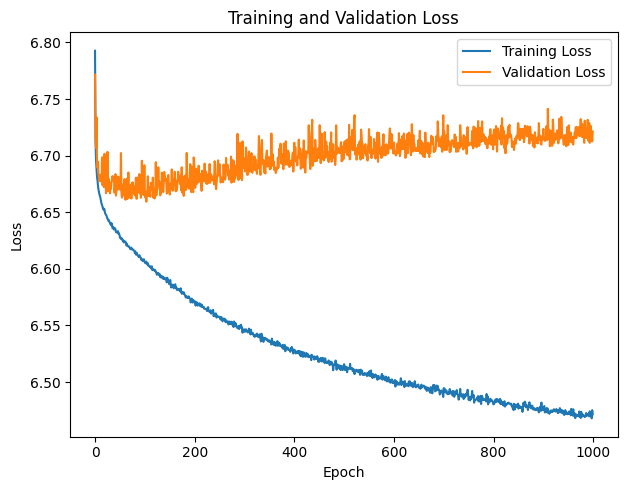

In [ ]:
# Plotting Loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(loss_history, label='Training Loss')
plt.plot(val_history, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Assuming 'model' is your model instance
torch.save(model.state_dict(), 'models/model_weights_01142024.pth')
torch.save(model, 'models/model_01142024.pth')

# Evaluate embeddings

In [ ]:
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=False, drop_last=True)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False, drop_last=True)

# Get embeddings for the training and test set
train_xray_embeddings, train_optical_embeddings = dataset_embeddings(model, train_loader, device)
test_xray_embeddings, test_optical_embeddings = dataset_embeddings(model, test_loader, device)

# Print shapes of embeddings
print("Training Set Embeddings:")
print("X-ray Embeddings Shape:", train_xray_embeddings.shape)
print("Optical Embeddings Shape:", train_optical_embeddings.shape)

print("\nTest Set Embeddings:")
print("X-ray Embeddings Shape:", test_xray_embeddings.shape)
print("Optical Embeddings Shape:", test_optical_embeddings.shape)


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Training Set Embeddings:
X-ray Embeddings Shape: (30720, 128)
Optical Embeddings Shape: (30720, 128)

Test Set Embeddings:
X-ray Embeddings Shape: (13312, 128)
Optical Embeddings Shape: (13312, 128)


#### PCA

In [ ]:
# 0.8 arcsec sep (0:3 arcmin off axis), 1.2 arcsec (3:5 arcmin), 2 arcsec sep (5:-> arcmin)

In [ ]:
from sklearn.decomposition import PCA

# Perform PCA
pca = PCA(n_components=2)
xray_pca = pca.fit_transform(train_xray_embeddings)
optical_pca = pca.transform(train_optical_embeddings)  # Use the same PCA fit

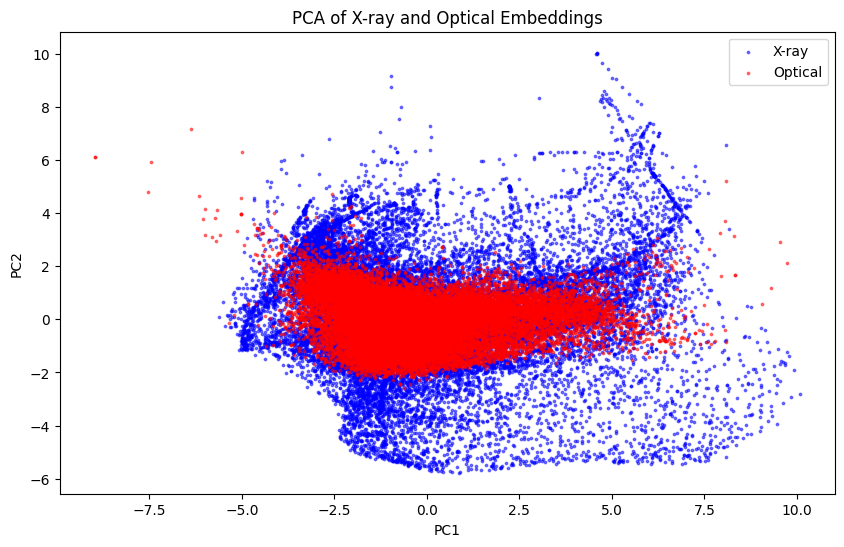

In [ ]:
# Plot
plt.figure(figsize=(10, 6))
plt.scatter(xray_pca[:, 0], xray_pca[:, 1], color='blue', alpha=0.5, s=3, label='X-ray')
plt.scatter(optical_pca[:, 0], optical_pca[:, 1], color='red', alpha=0.5, s=3, label='Optical')
plt.legend()
plt.title('PCA of X-ray and Optical Embeddings')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

#### Cosine similarity

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# Compute cosine similarity for positive pairs
positive_similarities = np.diag(cosine_similarity(train_xray_embeddings, train_optical_embeddings))

In [ ]:
n_samples = 2000  # Number of random samples to select
negative_similarities = np.zeros((train_xray_embeddings.shape[0], n_samples))

for i, xray_emb in enumerate(train_xray_embeddings):
    # Randomly select n_samples from optical embeddings, excluding the positive one
    indices = np.random.choice(len(train_optical_embeddings), n_samples, replace=False)
    random_optical_embs = train_optical_embeddings[indices]

    # Compute cosine similarity between xray_emb and the randomly selected optical embeddings
    negative_similarities[i] = cosine_similarity([xray_emb], random_optical_embs).flatten()


In [ ]:
# Example analysis
mean_positive_similarity = np.mean(positive_similarities)
mean_negative_similarity = np.mean(negative_similarities)

print("Mean Cosine Similarity for Positive Pairs:", mean_positive_similarity)
print("Mean Cosine Similarity for Negative Pairs:", mean_negative_similarity)

Mean Cosine Similarity for Positive Pairs: 0.43428704
Mean Cosine Similarity for Negative Pairs: 0.0700791071645621


In [ ]:
cos_Sim = cosine_similarity(train_xray_embeddings, train_optical_embeddings)

In [ ]:
from sklearn.metrics import roc_curve, auc

scores = cos_Sim.flatten()

#labels
labels = np.eye(cos_Sim.shape[0], dtype=int).flatten()

# roc
fpr, tpr, thresholds = roc_curve(labels, scores)
roc_auc = auc(fpr, tpr)


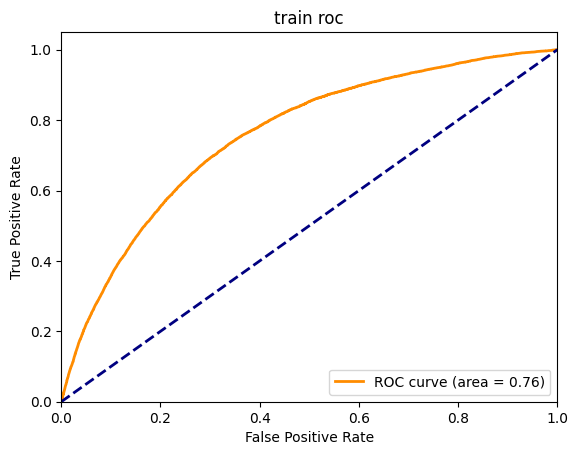

In [ ]:
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('train roc')
plt.legend(loc="lower right")

plt.show()


In [ ]:
cos_Sim_test = cosine_similarity(test_xray_embeddings, test_optical_embeddings)

In [ ]:
scores = cos_Sim_test.flatten()

#labels
labels = np.eye(cos_Sim_test.shape[0], dtype=int).flatten()

# roc
fpr, tpr, thresholds = roc_curve(labels, scores)
roc_auc = auc(fpr, tpr)

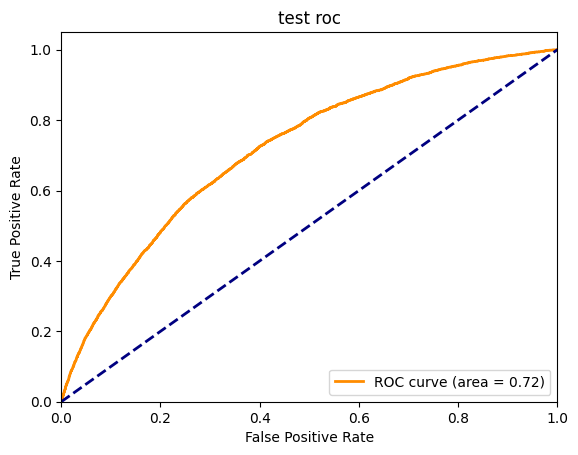

In [ ]:
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('test roc')
plt.legend(loc="lower right")

selected_thresholds = [0, 0.5, 0.8, 1]
plt.show()

In [ ]:
# Example threshold, adjust based on your analysis
similarity_threshold = 0.18

# Predictions: 1 if similarity is above the threshold, 0 otherwise
predictions = (cos_Sim_test.diagonal().flatten() > similarity_threshold).astype(int)


In [ ]:
cos_Sim_test.diagonal().mean()

0.21150057

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(np.ones(predictions.shape), predictions)

0.7492897727272727

In [ ]:
from sklearn.metrics import classification_report

# True labels should be a binary array indicating matching (1) or non-matching (0)
true_labels = labels

# Generate the classification report
report = classification_report(true_labels, predictions, target_names=['Non-Matching', 'Matching'])
print(report)


In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

cos_Sim = cosine_similarity(train_xray_embeddings, train_optical_embeddings)

threshold = 0.2

diagonal_mask = np.eye(cos_Sim.shape[0], dtype=bool)

num_above_threshold = np.sum((cos_Sim > threshold) & (~diagonal_mask))

total_non_diagonal = cos_Sim.size - cos_Sim.shape[0]

percentage_above_threshold = (num_above_threshold / total_non_diagonal) * 100

print(f"{threshold}: {percentage_above_threshold:.2f}%")


0.2: 41.27%


#### Classification

In [ ]:
def get_embedds(model, xray, optical):
    xray_embeddings = []
    optical_embeddings = []

    # Process each batch

    xray_batch = torch.tensor(xray).float().to(device)
    optical_batch = torch.tensor(optical).float().to(device)

    with torch.no_grad():  # Ensure no gradient computations
        emb_xray, emb_optical = model.get_embeddings(xray_batch, optical_batch)

    xray_embeddings.append(emb_xray.cpu())
    optical_embeddings.append(emb_optical.cpu())

    # Concatenate all collected embeddings
    xray_embeddings = torch.cat(xray_embeddings).numpy()
    optical_embeddings = torch.cat(optical_embeddings).numpy()

    return xray_embeddings, optical_embeddings

In [ ]:
from sklearn.impute import SimpleImputer
# Preprocess the data
X_ev_xray, Y_ev_xray = preprocess(df_pos, df_neg, feature_names_xray, skip_log_features)
X_ev_optical, Y_ev_optical = preprocess(df_pos, df_neg, feature_names_optical, skip_log_features)

indices_ev = np.arange(X_ev_xray.shape[0])

imp_mean = SimpleImputer(missing_values=np.nan, strategy='median')
X_ev_xray = imp_mean.fit_transform(X_ev_xray)
X_ev_optical = imp_mean.fit_transform(X_ev_optical)

X_ev_xray_emb, X_ev_optical_emb = get_embedds(model, X_ev_xray, X_ev_optical)

/content/drive/My Drive/science/stellarclip/scarf/astro_utils.py:8: RuntimeWarning: invalid value encountered in log10
  np.log10(1 + df[feature].values) if feature not in skip_log_features else df[feature].values


In [ ]:
# bottleneck layer for the representations
#

In [ ]:
X_ev_emb = np.concatenate([X_ev_xray_emb, X_ev_optical_emb], axis=1)

In [ ]:
X_ev_classifier = np.concatenate([X_ev_xray, X_ev_optical], axis=1)

In [ ]:
!pip install torcheval

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.2/179.2 kB 3.2 MB/s eta 0:00:00


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from torcheval.metrics import BinaryAccuracy

# Define the neural network class
class BinaryClassifier(nn.Module):
    def __init__(self, input_size):
        super(BinaryClassifier, self).__init__()
        # Define the architecture
        self.fc1 = nn.Linear(input_size, 32)  # First fully connected layer
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(32, 16)
        self.relu2 = nn.ReLU()
        self.dropout = nn.Dropout(p=0.1)
        self.fc3 = nn.Linear(16, 1)

        # 64-16-4

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.dropout(x)
        x = self.fc3(x)
        return torch.sigmoid(x)  # Sigmoid activation for binary classification

# Assuming input features size (modify according to your data)
input_size = 128 # Example input size, change as needed

# Initialize the model
model = BinaryClassifier(input_size)

# Loss function (Binary Cross-Entropy)
criterion = nn.BCELoss()

# Optimizer (e.g., Adam)
optimizer = optim.Adagrad(model.parameters(), lr=0.01)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from torcheval.metrics import BinaryAccuracy

# Define the neural network class
class BinaryClassifier(nn.Module):
    def __init__(self, input_size):
        super(BinaryClassifier, self).__init__()
        # Define the architecture
        self.fc1 = nn.Linear(input_size, 1)  # First fully connected layer

        # 64-16-4

    def forward(self, x):
        x = x.float().to(device)
        x_xray, x_optical = model.get_embeddings(x[:,0:5], x[:,5:])
        x = torch.concatenate([x_xray, x_optical], axis=1)
        x = self.fc1(x)
        return torch.sigmoid(x)  # Sigmoid activation for binary classification

# Assuming input features size (modify according to your data)
input_size = 256 # Example input size, change as needed

# Initialize the model
model_classifier = BinaryClassifier(input_size)

# Loss function (Binary Cross-Entropy)
criterion = nn.BCELoss()

# Optimizer (e.g., Adam)
optimizer = optim.Adagrad(model_classifier.parameters(), lr=0.01)

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(torch.tensor(X_ev_classifier), torch.tensor(Y_ev_optical), stratify= torch.tensor(Y_ev_optical), test_size=0.2, random_state=42)

# Create data loaders
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

val_dataset = TensorDataset(X_val, y_val)
val_loader = DataLoader(val_dataset, batch_size=32)

# Lists to keep track of losses
train_losses = []
val_losses = []
train_accs, val_accs = [], []

In [ ]:
# Training loop
binary_accuracy = BinaryAccuracy()
for epoch in range(1000):  # Number of epochs
    model.train()
    model_classifier.train()  # Set the model to training mode
    train_loss, train_acc = 0, 0
    binary_accuracy.reset()
    for inputs, targets in train_loader:
        # Forward pass
        outputs = model_classifier(inputs)
        loss = criterion(outputs, targets.reshape(-1, 1).float())
        train_acc += binary_accuracy.update(outputs.reshape(-1), targets.reshape(-1).float()).compute().detach()
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    train_loss /= len(train_loader)
    train_acc /= len(train_loader)
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    # Validation
    model_classifier.eval()
    model.eval() # Set the model to evaluation mode
    val_loss, val_acc = 0, 0
    binary_accuracy.reset()
    with torch.no_grad():
        for inputs, targets in val_loader:
            outputs = model_classifier(inputs)
            val_loss += criterion(outputs, targets.reshape(-1, 1).float()).item()

    val_loss /= len(val_loader)
    out_whole = model_classifier(X_val.float())
    val_acc = binary_accuracy.update(out_whole.squeeze(), y_val.float()).compute()
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

Epoch 1, Train Loss: 0.5846, Train Acc: 0.6652, Val Loss: 0.5707, Val Acc: 0.6947
Epoch 2, Train Loss: 0.5783, Train Acc: 0.6833, Val Loss: 0.5669, Val Acc: 0.6948
Epoch 3, Train Loss: 0.5782, Train Acc: 0.6816, Val Loss: 0.5629, Val Acc: 0.6925
Epoch 4, Train Loss: 0.5774, Train Acc: 0.6764, Val Loss: 0.5637, Val Acc: 0.6964
Epoch 5, Train Loss: 0.5776, Train Acc: 0.6833, Val Loss: 0.5639, Val Acc: 0.6980
Epoch 6, Train Loss: 0.5780, Train Acc: 0.6780, Val Loss: 0.5633, Val Acc: 0.6973
Epoch 7, Train Loss: 0.5769, Train Acc: 0.6804, Val Loss: 0.5619, Val Acc: 0.6956
Epoch 8, Train Loss: 0.5757, Train Acc: 0.6835, Val Loss: 0.5615, Val Acc: 0.6967
Epoch 9, Train Loss: 0.5769, Train Acc: 0.6828, Val Loss: 0.5608, Val Acc: 0.6979
Epoch 10, Train Loss: 0.5752, Train Acc: 0.6822, Val Loss: 0.5612, Val Acc: 0.6977
Epoch 11, Train Loss: 0.5751, Train Acc: 0.6827, Val Loss: 0.5724, Val Acc: 0.6977
Epoch 12, Train Loss: 0.5749, Train Acc: 0.6835, Val Loss: 0.5651, Val Acc: 0.6978
Epoch 13, Tra

In [ ]:
# Try using a linear classifier
# All the hard work is in the embeddings
# Maybe the embeddings is good

In [ ]:
# Try computing the validation loss in the embedding model (definitely). Consider early stopping. Smaller number of dimensions.

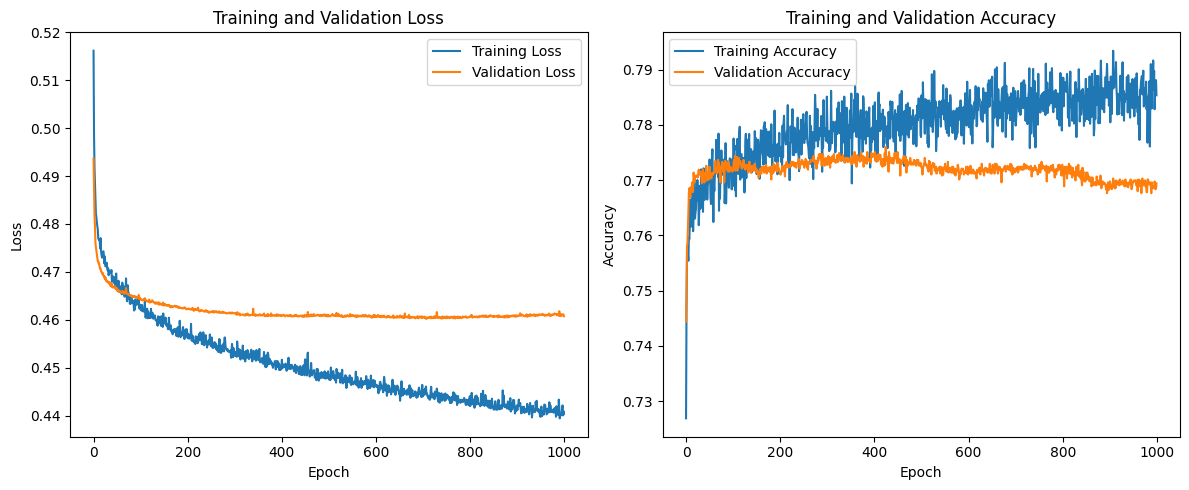

In [ ]:
# Plotting Loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plotting Accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Training Accuracy')
plt.plot(val_accs, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
state = torch.load('./models/classifier_2000_a.pth')
model.load_state_dict(state['state_dict'])
optimizer.load_state_dict(state['optimizer'])

In [ ]:
# state = {
#     'epoch': epoch,
#     'state_dict': model.state_dict(),
#     'optimizer': optimizer.state_dict()
# }
# torch.save(state, './models/classifier_2000_a.pth')

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Assuming you have a model, validation loader (val_loader), and criterion defined

model.eval()
with torch.no_grad():
    # Forward pass with the entire validation set
    outputs = model(X_train.float())
    outputs = outputs.squeeze()  # Remove the extra dimension if necessary
    val_loss = criterion(outputs, y_train.float()).item()

    # Convert outputs to probabilities and round them to get predictions
    probs = outputs.cpu().numpy()
    preds = probs > 0.5
    targets = y_train.cpu().numpy()

    # Calculate metrics
    acc = accuracy_score(targets , preds)
    precision = precision_score(targets, preds)
    recall = recall_score(targets, preds)
    f1 = f1_score(targets, preds)
    auc = roc_auc_score(targets, probs)

acc: 0.7872
Validation Loss: 0.4376
Precision: 0.7484
Recall: 0.8652
F1 Score: 0.8026
AUC: 0.8678


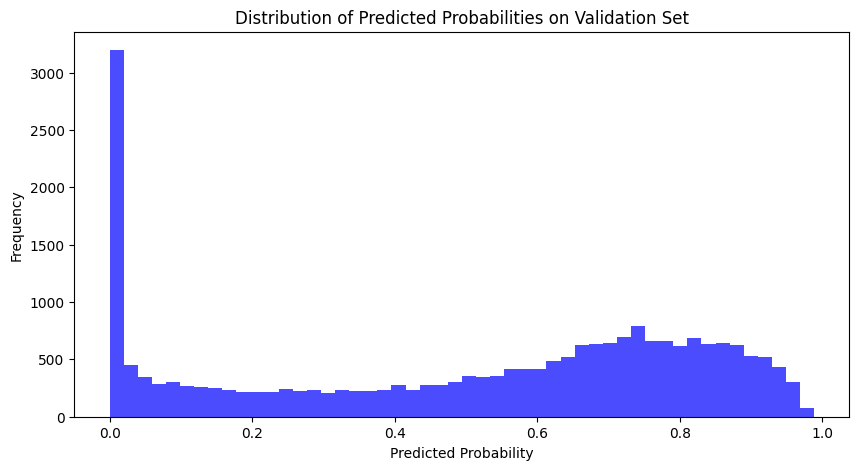

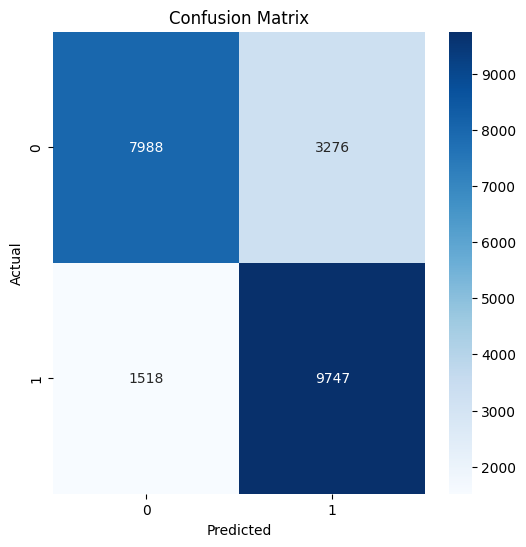

In [ ]:
# Print comprehensive metrics report
print(f"acc: {acc:.4f}")
print(f"Validation Loss: {val_loss:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"AUC: {auc:.4f}")

# Plotting histogram of predicted probabilities
plt.figure(figsize=(10, 5))
plt.hist(probs, bins=50, color='blue', alpha=0.7)
plt.title('Distribution of Predicted Probabilities on Validation Set')
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')
plt.show()

# Plot confusion matrix
cm = confusion_matrix(targets, preds)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [ ]:
# Calculate metrics
precision = precision_score(all_targets, all_preds)
recall = recall_score(all_targets, all_preds)
f1 = f1_score(all_targets, all_preds)
auc = roc_auc_score(all_targets, all_probs)

# Print comprehensive metrics report
print(f"Validation Loss: {val_loss:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"AUC: {auc:.4f}")

# Plotting histogram of predicted probabilities
plt.figure(figsize=(10, 5))
plt.hist(all_probs, bins=50, color='blue', alpha=0.7)
plt.title('Distribution of Predicted Probabilities on Validation Set')
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')
plt.show()

# Plot confusion matrix
cm = confusion_matrix(all_targets, all_preds)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

ValueError: ignored